**By Philippe Nguyen**

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
import time
from datetime import datetime

%matplotlib inline

# Global land-ocean temperature index

### Import data

In [2]:
d = np.genfromtxt('data2.txt', delimiter=(5,10,10))
ti = pd.DataFrame(d, columns=['year','annual', '5-year']) #ti = temperature index

# Data without 2015-16
ti1 = ti[ti['year']<2015]
yearsDec1 = np.arange(1880, 2015, 9.) + 4
tiDec1 = [np.mean(ti[(ti['year']>=1880+i*9) & (ti['year']<1880+9*(i+1))]['annual']) for i in range(len(yearsDec1))]
tiDec1Std = [np.std(ti[(ti['year']>=1880+i*9) & (ti['year']<1880+9*(i+1))]['annual']) for i in range(len(yearsDec1))]

# 2015-16 data
yearsDec2 = 2015.5
tiDec2 = np.mean(ti[(ti['year']>2014) & (ti['year']<2017)]['annual'])
tiDec2Std = np.std(ti[(ti['year']>2014) & (ti['year']<2017)]['annual'])

# Combined data
yearsDec = np.append(yearsDec1, yearsDec2)
tiDec = np.append(tiDec1, tiDec2)
tiDecStd = np.append(tiDec1Std, tiDec2Std)

### Sigmoid fit by $\chi^2$ minimization

In [3]:
sigm = lambda x, A, B, C, D: D + (A - D)/(1 + (x/C)**B)
chiSq = lambda obs, exp: (1/(len(obs)-4)) * np.sum((obs - exp)**2/exp)

In [4]:
vals = [[-.4, -.2], [40., 80.], [2000, 3000], [300000, 400000]]
csMin = 1000
csConverge = 1e-5
t0 = time.clock()
while np.abs(csMin) > csConverge:
    A, B, C, D = [( (x[1]-x[0]) * np.random.random(1) + x[0])[0] for x in vals]
    csMin = chiSq(tiDec, sigm(yearsDec, A, B, C, D))
dt = time.clock()-t0

print('Chi-square minimization completed in {:.2f} seconds.\nFinal results:\
\nA = {:.3f}, B = {:.1f}, C = {}, D = {},\nchi-sq = {}'.format(dt, A, B, C, D, csMin))

tiDecFit = sigm(yearsDec, A, B, C, D)
resSigm = (tiDec - tiDecFit)/np.std(tiDec - tiDecFit)
resSigmErr = tiDecStd/np.std(tiDec - tiDecFit)
print('2050 forecast, sigmoidal fit: {:.3f} deg C'.format(sigm(2050,A,B,C,D)))

Chi-square minimization completed in 4.18 seconds.
Final results:
A = -0.296, B = 50.2, C = 2581.0739762617895, D = 321624.543699737,
chi-sq = -4.151781535811453e-08
2050 forecast, sigmoidal fit: 2.756 deg C


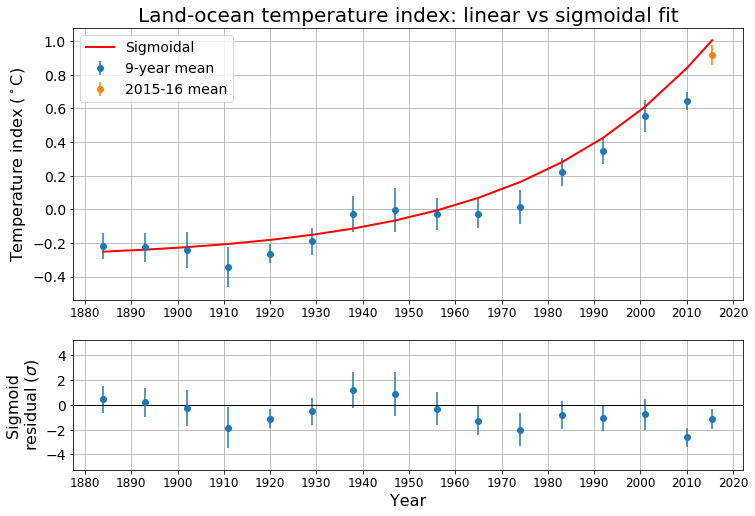

In [5]:
plt.figure(figsize=(12,11))
plt.subplot(2,1,1)
plt.errorbar(yearsDec1, tiDec1, yerr=tiDec1Std, fmt='o', label='9-year mean')
plt.errorbar(yearsDec2, tiDec2, yerr=tiDec2Std, fmt='o', label='2015-16 mean')
plt.plot(yearsDec, tiDecFit, 'r', lw=2, label='Sigmoidal')
plt.xticks(np.arange(1880, 2030, 10), size=12)
plt.yticks(size=14)
plt.title('Land-ocean temperature index: linear vs sigmoidal fit', size=20)
plt.ylabel('Temperature index ($^\circ$C)', size=16)
plt.legend(loc='upper left', fontsize=14)
plt.grid()

plt.subplot(4,1,3)
plt.axhline(y=0, lw=1, color='k')
plt.errorbar(yearsDec, resSigm, yerr=resSigmErr, fmt='o')
plt.ylim(-2*max(np.abs((resSigm))), 2*max(np.abs((resSigm))))
plt.xticks(np.arange(1880, 2030, 10), size=12)
plt.yticks(size=14)
plt.title('')
plt.xlabel('Year', size=16)
plt.ylabel('Sigmoid\nresidual ($\sigma$)', size=16)
plt.grid()
plt.show()

# Flood gauge data
### Import and manage data

In [6]:
cols1 = ['name', 'lat', 'long', 'datetime', 'gauge']
rivers_full = pd.read_csv('rivers.csv', names=cols1)

# Format date-time data, then bin data into 3-hour bins (summing up gauge levels)
date_time = [(x[:10] + '-' + str(3*int(int(x[11:13])/3)).zfill(2)) for x in rivers_full['datetime']]
rivers_full['datetime'] = date_time
rivers_3h = rivers_full.groupby(['name', 'datetime']).mean().reset_index()
rivers_3h['year'] = [x[:4] for x in rivers_3h['datetime']]
rivers_3h['month'] = [x[5:7] for x in rivers_3h['datetime']]
rivers_3h['day'] = [x[8:10] for x in rivers_3h['datetime']]
rivers_3h['hour'] = [x[11:13] for x in rivers_3h['datetime']]

# Get hours since 2017-01-01-00
x0_datetime = datetime(year=2017, month=1, day=1)
hr_since = [int((datetime.strptime(x,'%Y-%m-%d-%H') - x0_datetime).total_seconds()/3600) for x in rivers_3h['datetime']]
rivers_3h['abs hours'] = np.array([int(x/3)*3 for x in hr_since])
rivers_3h = rivers_3h[rivers_3h['abs hours'] >= 0]

### First look
I gathered ~150 coordinate points along the Willamette river via the Google Maps line-drawing tool, and copied it to a text file. We can use this to get an idea of where the 22 river gauges are in relation to the Willamette. I also used `mapcustomizer.com` to map all the gauge locations on a Google maps satellite view for comparison.

In [7]:
with open('WillametteRiverCoordsRaw.txt') as file:
    coordsStrings = file.read().split(',0\n')
    will_locs = []
    for i in range(len(coordsStrings)):
        will_locs.append([float(coordsStrings[i].split(',')[j]) for j in [0,1]])
will_locs = np.array(will_locs)

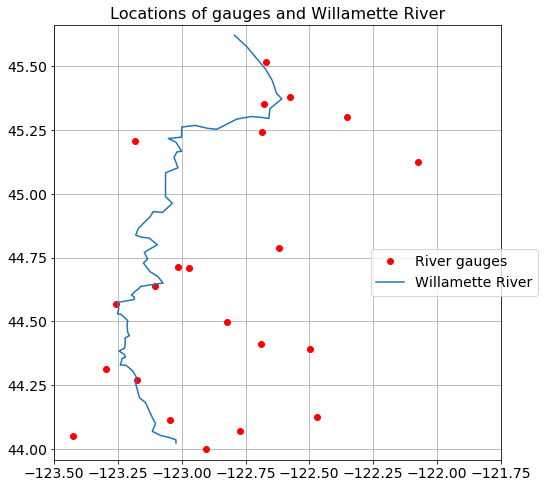

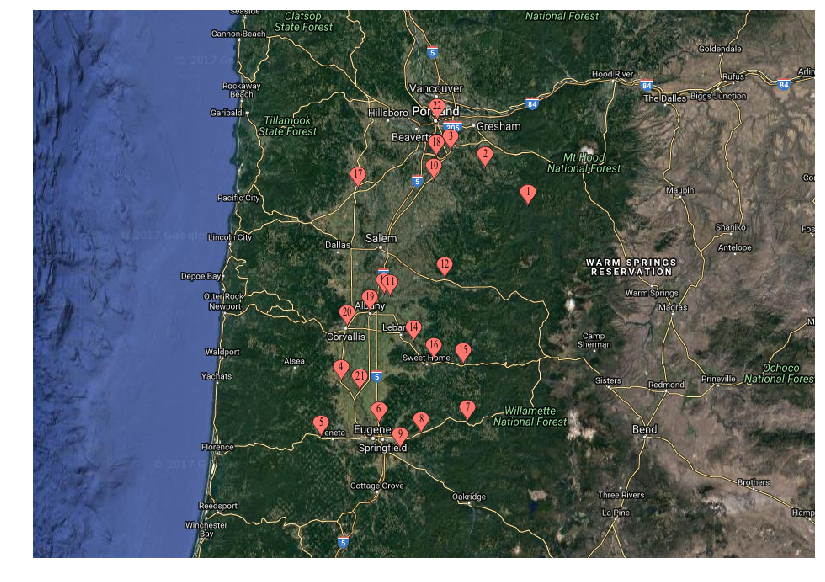

In [17]:
plt.figure(figsize=(8,8))
plt.plot(gauges_locs[0], gauges_locs[1], 'ro', label='River gauges')
plt.plot(will_locs.T[0][::2], will_locs.T[1][::2], '-', label='Willamette River')
plt.axis('equal')
plt.xticks(np.arange(-123.5, -121.5, .25), size=14)
plt.yticks(np.arange(44, 45.7, .25), size=14)
plt.title('Locations of gauges and Willamette River', size=16)
plt.grid()
plt.legend(fontsize=14, bbox_to_anchor=(1.1,.5))
plt.show()

plt.figure(figsize=(14,14))
gauge_map = mplimg.imread('gaugeMap.png')
plt.imshow(gauge_map)
plt.axis('off')
plt.show()

### Separate data by river

In [19]:
import re

regex1 = r"(\w+) RIVER "
regex2 = r"(\w+) R "
river_names = []
for gauge in list(set(rivers_3h['name'])):
    if re.search(regex1, gauge):
        river_names.append(gauge.split(' RIVER ')[0])
    elif re.search(regex2, gauge):
        river_names.append(gauge.split(' R ')[0])
river_names = list(set(river_names))
river_names.sort()

In [20]:
# Save individual river data to csv files in /rivers/ directory
for name in river_names:
    filename = 'rivers/' + name.replace(',','').replace(' ','_') + '.csv'
    indx = [i for i in range(len(rivers_3h['name'])) if rivers_3h['name'].iloc[i][:len(name)] == name]
    rivers_3h.iloc[indx].to_csv(filename)
# River names
with open('river_names.txt', 'w') as file:
    for name in river_names: file.write('{}\n'.format(name))

### Highest and lowest median-value rivers

In [16]:
# Dictionary of river dataframes, labeled by river name
riverDFs = {}
# Dictionary of river gauge info
riverInfo = {}
with open('river_names.txt', 'r') as file:
    river_names = file.read().splitlines()
for name in river_names:
    filename = 'rivers/' + name.replace(',','').replace(' ','_') + '.csv'
    riverDFs[name] = pd.read_csv(filename)[['name', 'lat', 'long', 'month', 'abs hours', 'gauge']]
    riverDFs[name] = riverDFs[name][riverDFs[name]['gauge'] >=0]
    
    gauge_names = riverDFs[name][['name']].drop_duplicates().reset_index()
    riverInfoEntry = pd.DataFrame([], columns=['name','lat','long'])
    for index, gauge_name in riverDFs[name][['name']].drop_duplicates().iterrows():
        gaugeInfo = riverDFs[name][riverDFs[name]['name']==gauge_name[0]].iloc[0][['name', 'lat', 'long']]
        riverInfoEntry = riverInfoEntry.append(gaugeInfo)
    riverInfo[name] = riverInfoEntry.reset_index(drop=True)
    
gaugesInfo = pd.concat([item[1] for item in riverInfo.items()]).reset_index(drop=True)
gauges_locs = np.array([gaugesInfo['long'], gaugesInfo['lat']])

In [21]:
medians = []
for name in river_names:
    med = riverDFs[name][riverDFs[name]['month'] < 5]['gauge'].median()
    medians.append([name, med])
medians_DF = pd.DataFrame(medians, columns=['name', 'median'])
medians_DF.sort_values('median')

,name,median
2,MCKENZIE,4.445000
3,MIDDLE FORK WILLAMETTE,4.527500
1,LONG TOM,6.281667
7,SOUTH SANTIAM,6.286429
6,SANTIAM,6.981471
9,TUALATIN,9.031250
10,WILLAMETTE,10.749583
5,NORTH SANTIAM,12.316667
4,MOLALLA,13.377500
0,CLACKAMAS,14.513750


The highest median is in South Yamhill at 26.7 ft, and the lowest is 4.4 ft on the McKenzie.

In [22]:
def slope_of_gauge(df):
    slope = [0]
    for i in range(len(df)-1):
        rise = df['gauge'].iloc[i+1]-df['gauge'].iloc[i]
        run = df['abs days'].iloc[i+1]-df['abs days'].iloc[i]
        slope.append(rise/run)
    return slope

In [23]:
# Higher river (SOUTH YAMHILL)
hi_river = riverDFs['SOUTH YAMHILL'][riverDFs['SOUTH YAMHILL']['month'] < 5][['abs hours', 'gauge']]
hi_river = hi_river.groupby('abs hours').mean().reset_index() # Average over gauges per time-step
hi_river['abs days'] = [int(x/24) for x in hi_river['abs hours']] # Convert hours to days for slope-smoothing
hi_river_days = hi_river.groupby('abs days').mean().reset_index() # Data binned by day
hi_river_days['slope'] = slope_of_gauge(hi_river_days) # Get slope
hi_river_steepest = hi_river_days.loc[hi_river_days['slope'].idxmax()] # Maximum slope

# Lower river (MCKENZIE)
low_river = riverDFs['MCKENZIE'][riverDFs['MCKENZIE']['month'] < 5][['abs hours', 'gauge']]
low_river = low_river.groupby('abs hours').mean().reset_index() # Avg over gauges per time-step
low_river['abs days'] = [int(x/24) for x in low_river['abs hours']] # Convert hours to days for slope-smoothing
low_river_days = low_river.groupby('abs days').mean().reset_index() # Data binned by day
low_river_days['slope'] = slope_of_gauge(low_river_days) # Get slope
low_river_steepest = low_river_days.loc[low_river_days['slope'].idxmax()] # Maximum slope

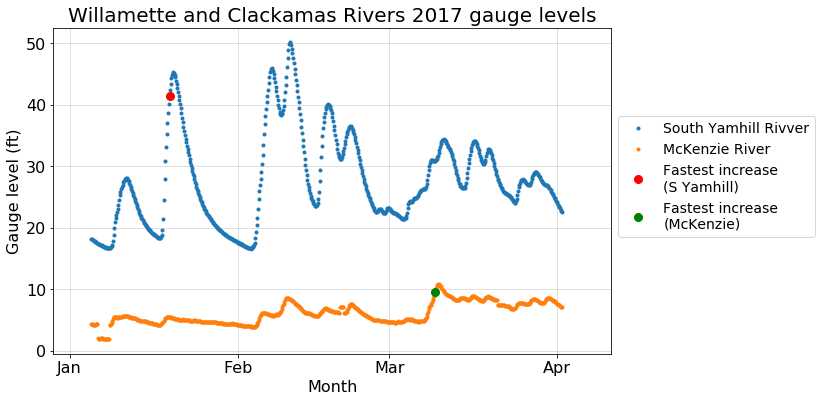

In [24]:
plt.figure(figsize=(10,6))
plt.plot(hi_river['abs hours']/24, hi_river['gauge'], '.', label='South Yamhill Rivver')
plt.plot(low_river['abs hours']/24, low_river['gauge'], '.', label='McKenzie River')
plt.plot(hi_river_steepest['abs hours']/24, hi_river_steepest['gauge'], 'ro', markersize=8, label='Fastest increase\n(S Yamhill)')
plt.plot(low_river_steepest['abs hours']/24, low_river_steepest['gauge'], 'go', markersize=8, label='Fastest increase\n(McKenzie)')
plt.xticks([0, 31, 59, 90, 120], ['Jan', 'Feb', 'Mar', 'Apr', 'Jun'], size=16)
plt.yticks(size=16)
plt.xlim(-3,100)
plt.title('Willamette and Clackamas Rivers 2017 gauge levels', size=20)
plt.xlabel('Month', size=16)
plt.ylabel('Gauge level (ft)', size=16)
plt.grid(alpha=.5)
plt.legend(fontsize=14,bbox_to_anchor=[1,.75])
plt.show()

### "Alarm event" durations

In [25]:
# name = 'SOUTH YAMHILL'
alarm_DFs = {}
for name in river_names:
    alarm = 2*riverDFs[name]['gauge'].min()
    river_alarm = riverDFs[name][['abs hours', 'gauge']].sort_values('abs hours').groupby('abs hours').mean().reset_index()
    # river_alarm[river_alarm['gauge'] < alarm]
    duration = [0]
    if river_alarm['gauge'].iloc[0] < alarm:
        alarm_start = []
    else:
        alarm_start = [river_alarm['abs hours'].iloc[0]]
    for i in range(1,len(river_alarm)):
        if river_alarm['gauge'].iloc[i] >= alarm:
            duration[-1] += 3
            if (river_alarm['gauge'].iloc[i-1] < alarm):
                alarm_start.append(river_alarm['abs hours'].iloc[i])
        else: duration.append(0)
    duration = [x for x in duration if x > 0]
    alarm_DFs[name] = pd.DataFrame({'start': alarm_start, 'duration': duration})
print(alarm_DFs)

{'CLACKAMAS':    duration  start
0      2085     96, 'LONG TOM':    duration  start
0       186    198
1       210    411
2      1101    825
3       210   1974, 'MCKENZIE':    duration  start
0        27     96
1      2007    177, 'MIDDLE FORK WILLAMETTE':    duration  start
0       225   1737, 'MOLALLA': Empty DataFrame
Columns: [duration, start]
Index: [], 'NORTH SANTIAM':    duration  start
0      2085     96, 'SANTIAM':    duration  start
0       165    849
1       210   1107
2       123   1590
3       456   1728, 'SOUTH SANTIAM':    duration  start
0       150    186
1       153    408
2       705    828
3       609   1575, 'SOUTH YAMHILL':    duration  start
0        93    429
1       180    858
2        69   1116
3        57   1218
4        33   1644
5        27   1782, 'TUALATIN':    duration  start
0       327    996, 'WILLAMETTE':    duration  start
0      2088     96}


### Peak gauge levels by river latitude

In [26]:
t_peak = []
lat_peak = []
for name, river in riverDFs.items():
    peak = river.loc[river['gauge'].idxmax()]
    t_peak.append(peak['abs hours'])
    lat_peak.append(np.mean(river['lat']))

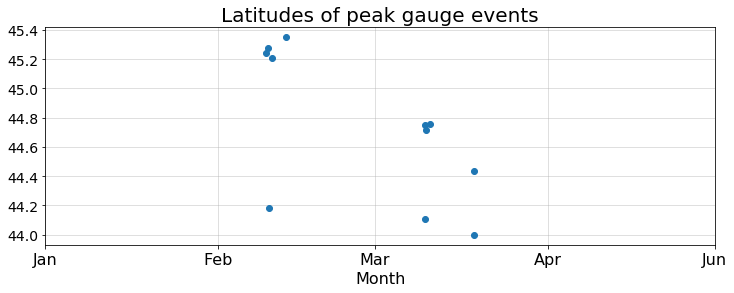

In [28]:
plt.figure(figsize=(12,4))
plt.plot(np.array(t_peak)/24, lat_peak, 'o')
plt.xticks([0, 31, 59, 90, 120], ['Jan', 'Feb', 'Mar', 'Apr', 'Jun'], size=16)
plt.yticks(size=14)
plt.title('Latitudes of peak gauge events', size=20)
plt.xlabel('Month', size=16)
plt.grid(alpha=.5)
plt.show()

# Proximity to Willamette River

### Distances and gauge-level differences between closest and farthest gauges (per river)

For each river, we will look at the distance and minimum gauge level of each gauge belonging to that river; we'll find the distance between the gauge closest to and the one farthest from the Willamette, as well as the difference between their minimum gauge levels.

In [29]:
gauges_dist = {}
gauges_dist_diffs = []
gauges_lvl_diffs = []
for river_name in river_names:
    gauge_names = np.array(riverDFs[river_name]['name'].drop_duplicates()) # Names of gauges for this river
    river_gauges_dist = {'name':[] , 'distance': [], 'min': []} # Distance & minimum level of each gauge from Willamette R
    for gauge_name in gauge_names:
        x0, y0 = np.array(gaugesInfo[gaugesInfo['name']==gauge_name][['long','lat']].iloc[0]) # gauge location
        distances = []
        # Find closest distance between gauge location and Willamette coords
        for i in range(len(will_locs)):
            [x1, y1] = will_locs[i]
            dist_x1x0 = (x1-x0)*111.320*np.cos(y0*np.pi/180)
            dist_y1y0 = (y1-y0)*110.574
            distances.append(np.linalg.norm([dist_x1x0, dist_y1y0]))
        river_gauges_dist['name'].append(gauge_name)
        river_gauges_dist['distance'].append(np.min(distances))
        # Find minimum gauge level for this gauge
        river_gauges_dist['min'].append(riverDFs[river_name][riverDFs[river_name]['name']==gauge_name]['gauge'].min())
    
    gauges_dist[river_name] = pd.DataFrame(river_gauges_dist).sort_values('distance')
    gauges_dist_diffs.append(gauges_dist[river_name].iloc[-1]['distance'] - gauges_dist[river_name].iloc[0]['distance'])
    gauges_lvl_diffs.append(np.max(river_gauges_dist['min']) - np.min(river_gauges_dist['min']))

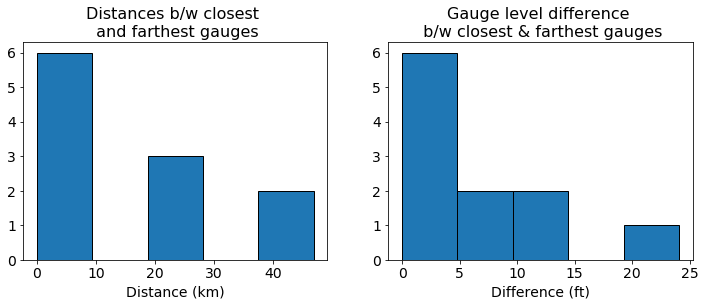

In [32]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(gauges_dist_diffs, bins=5, edgecolor='k', label='5 bins')
# plt.hist(gauges_dist_diffs, bins=10, edgecolor='k', label='10 bins')
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Distances b/w closest \n and farthest gauges', size=16)
plt.xlabel('Distance (km)', size=14)

plt.subplot(1,2,2)
plt.hist(gauges_lvl_diffs, bins=5, edgecolor='k', label='5 bins')
# plt.hist(gauges_lvl_diffs, bins=10, edgecolor='k', label='10 bins')
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Gauge level difference \n b/w closest & farthest gauges', size=16)
plt.xlabel('Difference (ft)', size=14)

plt.show()

# March 8 event

### Upper vs lower gauge

From here on, we're going to want to look at the farthest and closest gauge of each river that has at least two gauges.

In [33]:
upper_gauges = {}
lower_gauges = {}
for key, item in gauges_dist.items():
    if len(item)>1:
        upper_gauges[key] = item.loc[item['distance'].idxmax()]['name']
        lower_gauges[key] = item.loc[item['distance'].idxmin()]['name']

Let's take a look at how the upper and lower gauges (normalized to their minima) compare for each river.

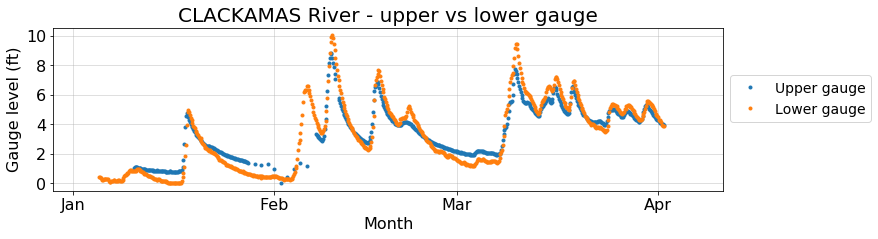

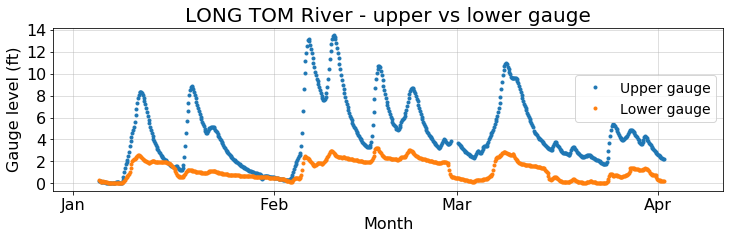

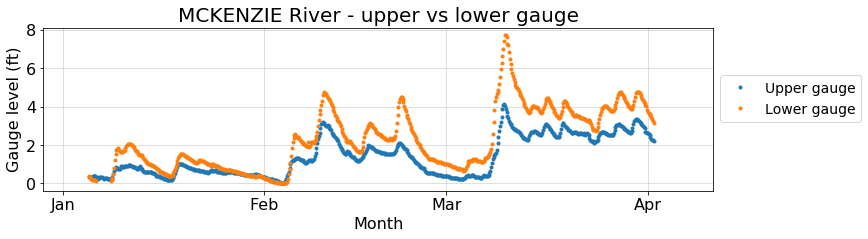

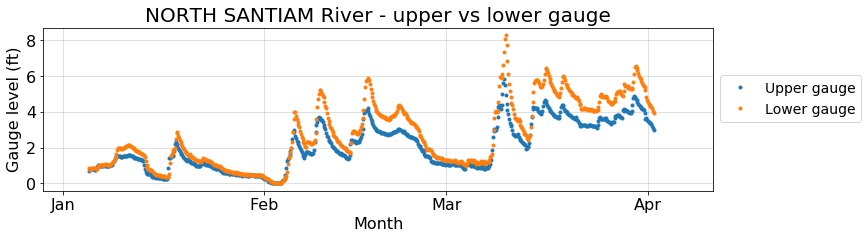

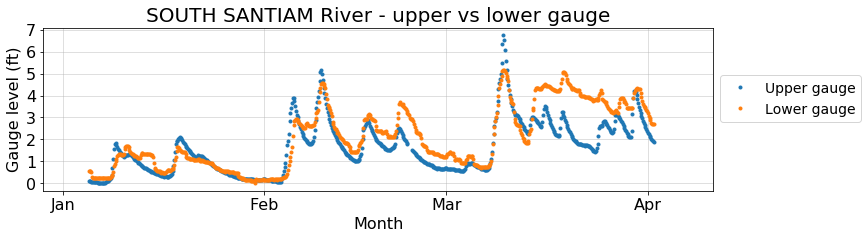

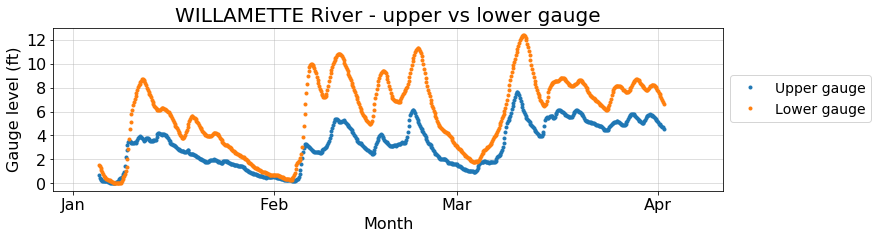

In [34]:
for river in river_names:
    if river in list(upper_gauges.keys()):
        gauge_upper = riverDFs[river][riverDFs[river]['name']==upper_gauges[river]][['name', 'abs hours', 'gauge']]
        gauge_lower = riverDFs[river][riverDFs[river]['name']==lower_gauges[river]][['name', 'abs hours', 'gauge']]
        plt.figure(figsize=(12,3))
        plt.plot(gauge_upper['abs hours']/24, gauge_upper['gauge']-gauge_upper['gauge'].min(), '.', label='Upper gauge')
        plt.plot(gauge_lower['abs hours']/24, gauge_lower['gauge']-gauge_lower['gauge'].min(), '.', label='Lower gauge')
        plt.xticks([0, 31, 59, 90, 120], ['Jan', 'Feb', 'Mar', 'Apr', 'Jun'], size=16)
        plt.yticks(size=16)
        plt.xlim(-3,100)
        plt.title('{} River - upper vs lower gauge'.format(river), size=20)
        plt.xlabel('Month', size=16)
        plt.ylabel('Gauge level (ft)', size=16)
        plt.grid(alpha=.5)
        plt.legend(fontsize=14,bbox_to_anchor=[1,.75])
        plt.show()

### Unbinned dataset
Now let's go back to the raw data and look at the March 8 event without binning the data.

In [35]:
# Re-import raw data, this time keep the minutes in datetime
cols1 = ['name', 'lat', 'long', 'datetime', 'gauge']
rivers_full = pd.read_csv('rivers.csv', names=cols1)
date_time = [(x[:10] + '-' + x[11:13] + '-' + x[14:16]) for x in rivers_full['datetime']]
rivers_full['datetime'] = date_time

# Get hours since 2017-01-01-00
x0_datetime = datetime(year=2017, month=1, day=1)
hr_since = [(datetime.strptime(x,'%Y-%m-%d-%H-%M') - x0_datetime).total_seconds()/3600 for x in rivers_full['datetime']]
rivers_full['abs hours'] = hr_since
rivers_full = rivers_full[(rivers_full['abs hours'] >= 1584) & (rivers_full['abs hours'] <= 1704)] # Look at Mar 8 + 5 days

In [36]:
# Dictionary of unbinned dataframes
riverDFs_unbinned = {}
with open('river_names.txt', 'r') as file:
    river_names = file.read().splitlines()
for name in river_names:
    indx = [i for i in range(len(rivers_full['name'])) if rivers_full['name'].iloc[i][:len(name)] == name]
    riverDFs_unbinned[name] = rivers_full.iloc[indx][['name', 'abs hours', 'gauge']]

I tried to get a linear as well as a linear + sine-wave fit working (brute-force style) but the second one wasn't working out. Still, we can look at linear fits to get some (barely) more accurate slopes for this event.

In [37]:
def leastSq(x1,y1):
    """Simple linear regression function"""
    N = len(x1)
    xx = np.sum(x1**2)
    xy = np.sum(x1*y1)
    delta = (N * xx) - np.sum(x1)**2
    # A = y‐intercept, B = slope
    A = (1/delta) * (xx*np.sum(y1) - np.sum(x1)*xy)
    B = (1/delta) * (N*xy - np.sum(x1)*np.sum(y1))
    yErr = np.sqrt(np.sum((y1 - A - B*x1)**2) / (N-2))
    AErr = yErr * np.sqrt(xx/delta)
    BErr = yErr * np.sqrt(N/delta) # uncertainty in slope
    return A, B, yErr, AErr, BErr

In [38]:
chiSq = lambda obs, exp: 1/(len(obs)-2) * np.sum((obs - exp)**2/exp)
linSin = lambda x,a,b,c,d,e: a*np.sin(b*x+c)+d*x+e

In [39]:
def linSinFit(x, y, param_bounds, converge):
    """Brute-force sine-wave plus linear fit"""
    csMin = 1000
    while np.abs(csMin) > converge:
        A, B, C, D, E = [((max(i)-min(i)) * np.random.random(1) + min(i))[0] for i in param_bounds]
        csMin = chiSq(y, linSin(x, A, B, C, D, E))
    return A, B, C, D, E, csMin

C:\Users\Philippe\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Philippe\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Linear fit:
Slope = 3.23 ft/day
Chi-Square = 4.47e-02


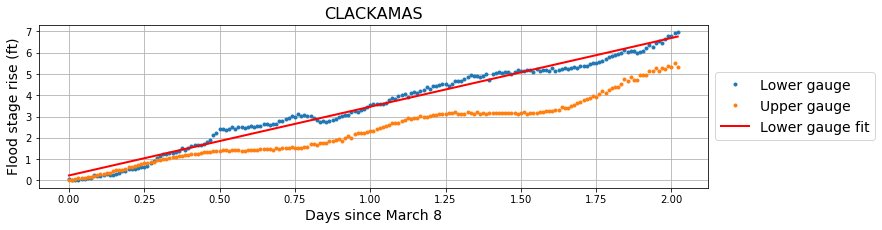

Linear fit:
Slope = 0.15 ft/day
Chi-Square = 1.11e-02


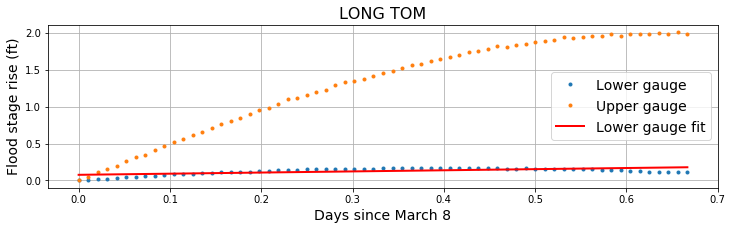

Linear fit:
Slope = 2.52 ft/day
Chi-Square = 5.14e-02


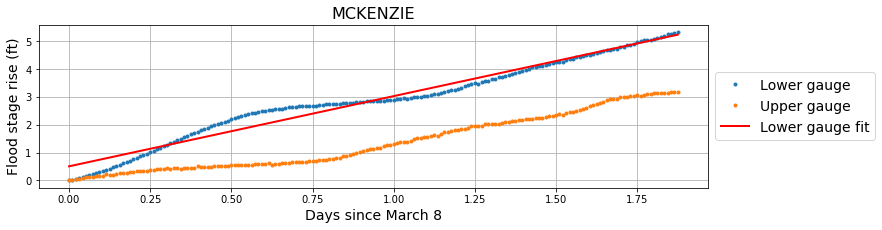

Linear fit:
Slope = 2.62 ft/day
Chi-Square = 8.25e-02


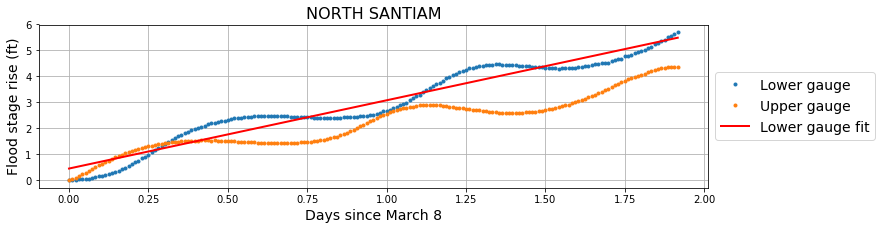

Linear fit:
Slope = 2.22 ft/day
Chi-Square = 1.92e-02


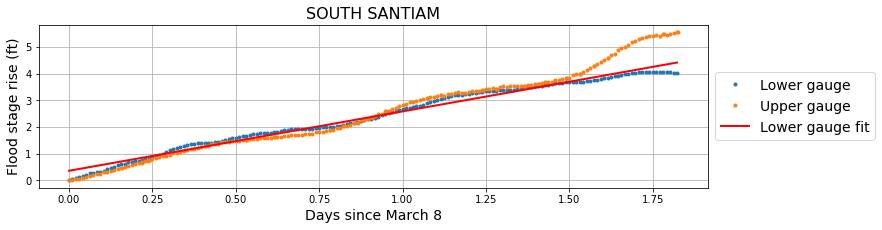

Linear fit:
Slope = 2.65 ft/day
Chi-Square = -2.81e-03


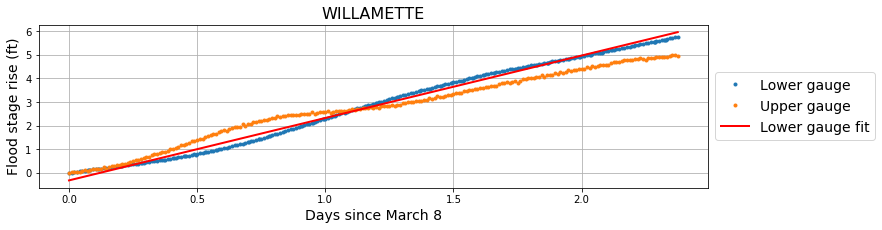

In [47]:
slope_upper = []
slope_lower = []
dt = []
for river in river_names:
    if river in list(upper_gauges.keys()):
#     if river == list(upper_gauges.keys())[0]:
        gauge_upper = riverDFs_unbinned[river][riverDFs_unbinned[river]['name']==upper_gauges[river]]
        gauge_lower = riverDFs_unbinned[river][riverDFs_unbinned[river]['name']==lower_gauges[river]]
        
        gauge_upper['abs days'] = [x/24 for x in gauge_upper['abs hours']] # Convert hours to days
        gauge_upper_peak = gauge_upper['gauge'].idxmax() # Get upper gauge max time
        gauge_upper_march = gauge_upper.loc[:gauge_upper_peak+1]

        gauge_lower['abs days'] = [x/24 for x in gauge_lower['abs hours']] # Convert hours to days
        gauge_lower_march = gauge_lower[gauge_lower['abs days'] <= gauge_upper.loc[gauge_upper_peak+1]['abs days']]
        
        # Linear fit
        x = gauge_lower_march['abs days']-66
        y = gauge_lower_march['gauge'] - gauge_lower_march['gauge'].min()
        x_upper = gauge_upper_march['abs days']-66
        y_upper = gauge_upper_march['gauge'] - gauge_upper_march['gauge'].min()
        A_lower, B_lower, yErr_lower, AErr_lower, BErr_lower = leastSq(x, y)
        A_upper, B_upper, yErr_upper, AErr_upper, BErr_upper = leastSq(x_upper, y_upper)
        slope_upper.append(B_upper)
        slope_lower.append(B_lower)
        dt.append(x.max() - x.min())
#         print(A1 + B1*5)
        print('Linear fit:\nSlope = {:.2f} ft/day\nChi-Square = {:.2e}'.format(B_lower, chiSq(y, A_lower + x*B_lower)))
        
        # Sine fit
#         param_bounds = [[-1, 1], [0,10], [-np.pi/2,np.pi/2], [-1,1], [-5,5]]
#         A2, B2, C2, D2, E2, csMin2 = linSinFit(x, y, param_bounds, 1e-1)
#         print('Non-linear fit:\nChi-Square = {:.2e}'.format(chiSq(y, linSin(x, A2, B2, C2, D2, E2))))
        
        plt.figure(figsize=(12,3))
        plt.plot(x, y, '.', label='Lower gauge')
        plt.plot(x_upper, y_upper, '.', label='Upper gauge')
        plt.plot(x, A_lower + x*B_lower, 'r-', lw=2, label='Lower gauge fit')
#         plt.plot(x_upper, A_upper + x_upper*B_upper, '-', label='Lower gauge\nlinear fit')
#         plt.plot(x, linSin(x, A2, B2, C2, D2, E2), '-', label='Lower gauge\nlinear fit')
        plt.title(river, size=16)
        plt.xlabel('Days since March 8', size=14)
        plt.ylabel('Flood stage rise (ft)', size=14)
        plt.legend(fontsize=14,bbox_to_anchor=[1,.75])
        plt.grid()
        plt.show()

Assuming that all the flow through the upper gauge ends up going through the lower gauge, I would have expected the slopes of the upper and lower gauges for each river to be about equal (perhaps with the lower one being a bit greater due to smaller tributaries merging). The differences between the upper- and lower-gauge slopes are summarized below.

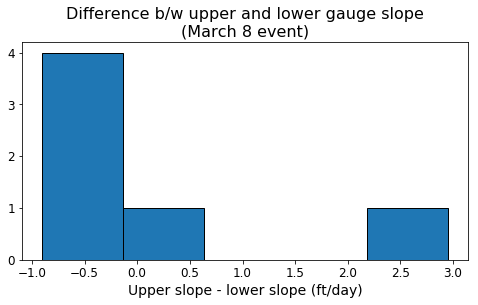

In [48]:
slope_diffs = np.array(slope_upper) - np.array(slope_lower)
plt.figure(figsize=(8,4))
plt.hist(slope_diffs, bins=5, edgecolor='k')
plt.xticks(size=12)
plt.yticks([0,1,2,3,4], size=12)
plt.title('Difference b/w upper and lower gauge slope\n(March 8 event)', size=16)
plt.xlabel('Upper slope - lower slope (ft/day)', size=14)
plt.show()

### Downtown Portland flood prediction
Let's see if we can predict the river stage in downtown Portland (gauge name `'WILLAMETTE RIVER AT PORTLAND, OR'`) by simply adding up the lower-gauge heights of all the rivers (apart from the Willamette of course).

In [49]:
prediction = sum(np.array(slope_lower[:-1])*np.array(dt[:-1]))
actual = slope_lower[-1]*dt[-1]
print('Predicted rise = {}\nActual rise = {}'.format(prediction, actual))

Predicted rise = 20.445249422388866
Actual rise = 6.28916343655837


Well that's weird. It seems the rise at the Portland gauge is pretty low, just about the same rise as most of the tributaries feeding into it.